## LSTM

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import time
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Dataset
from zipfile import ZipFile

In [ ]:
data_path_zip = '/content/drive/MyDrive/nturgbd_skeletons_s001_to_s017.zip'
extract_dir = '/content/drive/MyDrive/skeletons'
with ZipFile(data_path_zip) as zf:
    zf.extractall(extract_dir)

In [ ]:
class SkeletonDataSet:
    
    files = None
    action_classes = None
    
    def __init__(self, data_path, broken_files_path , chonk_len=45):
        self.data_path = data_path
        self.broken_files_path = broken_files_path
        self.chonk_len = chonk_len
        self.training_cameras = [1, 2, 3]
        self.training_classes = [5, 7, 20, 24, 27, 33, 38, 50, 72, 93]
    
    def read_data(self):
        labels = []
        files = []
        action_classes = {}
        counter = 0
        files_counter = {}

        with open(self.broken_files_path, 'r') as f:
            broken_files = f.read().split("\n")

        raw_files = os.listdir(self.data_path)
        num_frames = 0

        for filename in raw_files:
            if filename not in broken_files:
                action_class = int(filename[filename.find('A') + 1:filename.find('A') + 4])
                subject_id = int(filename[filename.find('P') + 1:filename.find('P') + 4])
                camera_id = int(filename[filename.find('C') + 1:filename.find('C') + 4])
                if action_class in self.training_classes and camera_id in self.training_cameras:  # and subject_id in training_subjects:
                    if action_class in action_classes:
                        if files_counter[action_class] < 120:
                            files.append([filename, action_classes[action_class]])
                            files_counter[action_class] = files_counter[action_class] + 1
                    else:
                        action_classes.update({action_class : counter})
                        files_counter.update({action_class : 1})
                        counter+=1
                        files.append([filename,action_classes[action_class]])
                        labels.append([action_class])
                        
        print("action classes: ", action_classes)
        print("action files: ", files_counter)
        
        self.files = files
        self.action_classes = action_classes
        
        return files, action_classes
    
    def get_nonzero_std(self, s): 
        index = s.sum(-1).sum(-1) != 0  
        s = s[index]
        if len(s) != 0:
            s = s[:, :, 0].std() + s[:, :, 1].std() + s[:, :, 2].std()  
        else:
            s = 0
        return s
    
    def read_skeleton_filter(self, file):
        with open(file, 'r') as f:
            skeleton_sequence = {}
            skeleton_sequence['numFrame'] = int(f.readline())
            skeleton_sequence['frameInfo'] = []
            for t in range(skeleton_sequence['numFrame']):
                frame_info = {}
                frame_info['numBody'] = int(f.readline())
                frame_info['bodyInfo'] = []

                for m in range(frame_info['numBody']):
                    body_info = {}
                    body_info_key = [
                        'bodyID', 'clipedEdges', 'handLeftConfidence',
                        'handLeftState', 'handRightConfidence', 'handRightState',
                        'isResticted', 'leanX', 'leanY', 'trackingState'
                    ]
                    body_info = {
                        k: float(v)
                        for k, v in zip(body_info_key, f.readline().split())
                    }
                    body_info['numJoint'] = int(f.readline())
                    body_info['jointInfo'] = []
                    for v in range(body_info['numJoint']):
                        joint_info_key = [
                            'x', 'y', 'z', 'depthX', 'depthY', 'colorX', 'colorY',
                            'orientationW', 'orientationX', 'orientationY',
                            'orientationZ', 'trackingState'
                        ]
                        joint_info = {
                            k: float(v)
                            for k, v in zip(joint_info_key, f.readline().split())
                        }
                        body_info['jointInfo'].append(joint_info)
                    frame_info['bodyInfo'].append(body_info)
                skeleton_sequence['frameInfo'].append(frame_info)

        return skeleton_sequence
    
    def read_xyz(self, file, max_body=1, num_joint=25):
        seq_info = self.read_skeleton_filter(file)
        data = np.zeros((max_body, seq_info['numFrame'], num_joint, 3))
        for n, f in enumerate(seq_info['frameInfo']):
            for m, b in enumerate(f['bodyInfo']):
                for j, v in enumerate(b['jointInfo']):
                    if m < max_body and j < num_joint:
                        data[m, n, j, :] = [v['x'], v['y'], v['z']]

                    else:
                        pass

        return data
    
    def create_coords_blocks(self, test_file):   
        frame_counter = 0
        new_labels = []
        new_frames = []
        blocks = []

        test_frames = self.read_xyz(self.data_path + test_file[0])[0]
        label = test_file[1]
        slice_len = self.chonk_len * int(len(test_frames)/self.chonk_len)


        for index in range(len(test_frames[:slice_len])):
            frame_counter += 1
            new_frames.append(test_frames[index].flatten())
            if frame_counter == self.chonk_len:
                frame_counter = 0
                blocks.append(np.array(new_frames))
                new_labels = new_labels + [label]
                new_frames = []


        return blocks, new_labels
    
    def mark_data(self):
        data = []
        labels = []
        ##########################################################################
        numbers = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0} #####
        ##################################################################
        for file in self.files:
            frames_blocks, label = self.create_coords_blocks(file)
            if label != [] and numbers[label[0]] <= 150:
                numbers[label[0]] += len(label)
                data += frames_blocks
                labels += label
        data_np = np.asarray(data)
        labels_np = np.asarray(labels)

        data_sq = data_np.reshape(len(data_np), -1)
        test_data = pd.DataFrame(data_sq)
        test_labels = pd.DataFrame(labels_np)
        test_data['labels'] = test_labels
        
        return test_data

In [ ]:
DATA_PATH = '/content/drive/MyDrive/skeletons/nturgb+d_skeletons/'
BROKEN_FILES_PATH = '/content/drive/MyDrive/skeletons/NTU_RGBD_samples_with_missing_skeletons.txt'

In [ ]:
data_skeleton = SkeletonDataSet(data_path=DATA_PATH, broken_files_path=BROKEN_FILES_PATH, chonk_len=50)

data_skeleton.read_data()

In [ ]:
df = data_skeleton.mark_data()

In [ ]:
df.to_csv('skeleton50.csv', index = False)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/skeleton50.csv')

In [ ]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,3711,3712,3713,3714,3715,3716,3717,3718,3719,3720,3721,3722,3723,3724,3725,3726,3727,3728,3729,3730,3731,3732,3733,3734,3735,3736,3737,3738,3739,3740,3741,3742,3743,3744,3745,3746,3747,3748,3749,labels
0,0.216129,0.185681,3.767784,0.228515,0.437528,3.691366,0.239707,0.684526,3.604562,0.209585,0.788544,3.579634,0.107013,0.609244,3.692309,0.097245,0.398946,3.755655,0.071003,0.378669,3.532924,0.093353,0.390710,3.513596,0.336767,0.574167,3.563899,0.393315,0.385455,3.594625,0.184091,0.377979,3.476574,0.163689,0.379102,3.465217,0.163389,0.188209,3.757957,0.193764,...,0.167334,0.183555,3.774702,0.190691,-0.123525,3.893249,0.238399,-0.409509,4.026902,0.201013,-0.469224,3.931501,0.274613,0.182725,3.731796,0.304508,-0.142474,3.805532,0.322268,-0.450023,3.938748,0.281184,-0.503231,3.955158,0.209986,0.613128,3.633733,-0.008305,0.376740,3.580781,0.003934,0.357284,3.581750,0.157428,0.392301,3.460259,0.171550,0.370148,3.459167,0
1,0.237631,0.235039,3.746806,0.246957,0.468998,3.670609,0.255474,0.698446,3.586321,0.227848,0.807023,3.567291,0.154777,0.633232,3.631342,0.116700,0.431494,3.779196,0.090475,0.250002,3.828635,0.079708,0.179805,3.836316,0.352451,0.603199,3.551970,0.357557,0.393218,3.567642,0.340194,0.201544,3.569023,0.328381,0.123842,3.582424,0.190233,0.238972,3.738866,0.225254,...,-0.023113,0.190250,3.611777,-0.040075,-0.179409,3.745232,-0.084005,-0.479908,3.848197,-0.128462,-0.528454,3.773151,0.067169,0.205584,3.611563,0.215996,-0.148972,3.708674,0.332963,-0.454162,3.938946,0.326120,-0.518298,3.929154,-0.021926,0.657663,3.489328,-0.283195,0.455689,3.514100,-0.285979,0.445472,3.509000,-0.022871,0.701316,2.982738,-0.008102,0.664465,2.972972,1
2,0.443868,-0.031092,4.133648,0.434343,0.196818,4.022484,0.423121,0.421168,3.902824,0.405972,0.529858,3.864884,0.299719,0.352171,3.978494,0.269514,0.150808,4.082292,0.208622,-0.000404,3.890462,0.206166,-0.025612,3.854596,0.533503,0.318441,3.875472,0.601852,0.129017,3.947255,0.486983,0.010958,3.814233,0.440476,-0.015098,3.761896,0.379933,-0.025538,4.118165,0.227432,...,0.386823,0.004249,4.093446,0.180862,-0.143242,3.875123,0.195900,-0.429326,4.048687,0.220299,-0.486212,3.955844,0.488235,0.018086,4.074064,0.334751,-0.155982,3.815258,0.451717,-0.470404,3.969688,0.474182,-0.526941,3.877042,0.419262,0.406249,3.943238,0.208120,0.608896,3.880145,0.172790,0.540568,3.877889,0.538015,0.285437,3.607140,0.541454,0.294485,3.597500,2
3,0.441684,0.011612,4.112082,0.428414,0.239035,4.017493,0.415520,0.462060,3.915770,0.396432,0.582545,3.895000,0.299567,0.393885,4.000058,0.122038,0.348188,3.977703,0.179522,0.505916,3.900860,0.197280,0.559249,3.893288,0.566536,0.548710,4.044987,0.531015,0.511592,3.790628,0.528315,0.338723,3.635660,0.529196,0.309657,3.625098,0.388299,0.004874,4.090465,0.180948,...,0.377227,-0.000447,4.097655,0.179252,-0.144708,3.868785,0.196270,-0.430140,4.038725,0.156564,-0.485833,3.951505,0.487860,-0.008144,4.045833,0.323235,-0.149049,3.786463,0.439853,-0.472182,3.954978,0.398295,-0.527512,3.867947,0.424741,0.387086,3.944188,0.219533,-0.103769,3.840647,0.199185,-0.086971,3.853000,0.419361,-0.082200,3.837892,0.410779,-0.026258,3.839000,2
4,0.286811,0.168139,3.734849,0.288774,0.415689,3.650531,0.290175,0.658193,3.557110,0.260253,0.775526,3.525290,0.176420,0.604293,3.637196,0.155090,0.405268,3.778336,0.138438,0.217206,3.833165,0.122691,0.178318,3.850277,0.401347,0.561101,3.522032,0.482151,0.353557,3.594829,0.501666,0.169162,3.607278,0.491992,0.106504,3.620773,0.234575,0.169397,3.723695,0.263884,...,0.182669,0.187920,3.750454,0.252303,-0.138766,3.874888,0.297160,-0.410755,3.979622,0.255796,-0.465776,3.887480,0.291139,0.173553,3.705562,0.097447,-0.030583,3.557076,-0.151165,-0.333917,3.449322,-0.189010,-0.389120,3.357108,0.222134,0.601262,3.651914,-0.003648,0.094003,3.819715,-0.007122,0.151750,3.826333,0.474957,0.068992,3.611121,0.488455,0.128277,3.603967,3


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 955 entries, 0 to 954
Columns: 3751 entries, 0 to labels
dtypes: float64(3750), int64(1)
memory usage: 27.3 MB


In [ ]:
labelsDict = {5: 'drop', 
          7: 'throw', 
          20: 'put on a hat/cap', 
          24: 'kicking something', 
          27: 'jump up', 
          33: 'check time (from watch)', 
          38: 'salute', 
          50: 'punching/slapping other person', 
          72: 'make victory sign',
          93: 'shake fist'}
LABELS = list(labelsDict.values())

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### LSTM

In [ ]:
class LSTM_net(nn.Module):
    # Для того, что бы инициализировать LSTM нам нужно указать:
    # input_dim - размерность входного тензора. тензор входит в формате (seq_len, batch, input_dim)
    # (batch_size, seq, inp_dim) - if batch_first=True
    # hidden_dim - размерность вектора состояния h
    # output_dim - размерность выхода
    # layer_num - количество скрытых слоев в сети
    def __init__(self, input_dim, hidden_dim, output_dim, layer_num):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.lstm = torch.nn.LSTM(input_dim, hidden_dim, layer_num, batch_first=True)
        self.dr = torch.nn.Dropout2d(0.1)
        self.fc = torch.nn.Linear(hidden_dim, output_dim)
        
        
    def forward(self,inputs):
        x = inputs
        lstm_out, (hn, cn) = self.lstm(x)
        out = self.fc(lstm_out[:,-1,:])
        return out

In [ ]:
n_hidden = 128
n_joints = 25*3
n_categories = len(LABELS)
n_layer = 2
rnn = LSTM_net(n_joints, n_hidden, n_categories, n_layer)
rnn.to(device)

LSTM_net(
  (lstm): LSTM(75, 128, num_layers=2, batch_first=True)
  (dr): Dropout2d(p=0.1, inplace=False)
  (fc): Linear(in_features=128, out_features=10, bias=True)
)

### Datasets

In [ ]:
class Skeleton_Dataset(Dataset):
    def __init__(self, file_path, chonk, transform=None):
        self.data = pd.read_csv(file_path)
        self.transform = transform
        self.labels = self.data.iloc[:,-1]
        self.chonk = chonk

    def __len__(self):
        return len(self.data) 
    
    def __getitem__(self, idx):
        item = np.asarray(self.data.iloc[idx,:-1]).reshape(self.chonk, 25*3)
        label = self.labels[idx]
        
        if self.transform != None:
            item = transform(item)

        return (item, label)

In [ ]:
dataset = Skeleton_Dataset(file_path="/content/drive/MyDrive/skeleton50.csv", chonk=50, transform=None)

In [ ]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
#     print(output.topk(5))
    return LABELS[category_i], category_i

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [ ]:
train_len = int(0.75*len(dataset))
test_len = len(dataset) - train_len

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_len, test_len])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

In [ ]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.0007
optimizer = optim.SGD(rnn.parameters(), lr=learning_rate, momentum=0.9)

all_losses = []
start = time.time()
counter = 0
for epoch in range(600):  
    current_loss = 0
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
    
        output = rnn(inputs.float())
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step() 


        current_loss += loss.item()
        category = LABELS[int(labels[0])]

        if counter % 500 == 0:
            guess, guess_i = categoryFromOutput(output)
            correct = '✓' if guess == category else '✗ (%s)' % category
            print('epoch : %d iter : %d (%s) %.4f  / %s %s' % (epoch, i, timeSince(start), loss, guess, correct))

        
        counter = counter + 1
    if counter % 100 == 0:
        all_losses.append(current_loss / 25)
        current_loss = 0

epoch : 0 iter : 0 (0m 0s) 2.2538  / check time (from watch) ✓
epoch : 11 iter : 5 (0m 18s) 2.0461  / put on a hat/cap ✗ (kicking something)
epoch : 22 iter : 10 (0m 36s) 2.0834  / put on a hat/cap ✗ (salute)
epoch : 33 iter : 15 (0m 53s) 2.1138  / kicking something ✗ (put on a hat/cap)
epoch : 44 iter : 20 (1m 11s) 2.0263  / kicking something ✗ (jump up)
epoch : 55 iter : 25 (1m 29s) 1.9101  / kicking something ✗ (drop)
epoch : 66 iter : 30 (1m 47s) 2.0447  / put on a hat/cap ✗ (throw)
epoch : 77 iter : 35 (2m 4s) 1.4855  / put on a hat/cap ✗ (salute)
epoch : 88 iter : 40 (2m 22s) 1.8322  / put on a hat/cap ✗ (throw)
epoch : 100 iter : 0 (2m 40s) 1.8783  / punching/slapping other person ✗ (check time (from watch))
epoch : 111 iter : 5 (2m 57s) 1.9528  / put on a hat/cap ✓
epoch : 122 iter : 10 (3m 16s) 1.8004  / put on a hat/cap ✓
epoch : 133 iter : 15 (3m 33s) 1.3811  / check time (from watch) ✓
epoch : 144 iter : 20 (3m 51s) 1.9733  / salute ✗ (punching/slapping other person)
epoch 

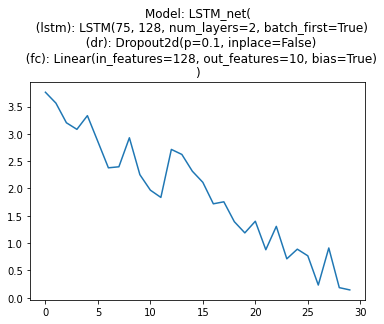

In [ ]:
plt. title('Model: ' + str(rnn))
plt.plot(list(range(0, len(all_losses))), all_losses)
plt.show()

In [ ]:
def result_model(model, test_loader):

    total = 0
    right = 0
    counter = 0

    rnn.eval()
    with torch.no_grad():
        for i, data in enumerate(test_loader, 0):
            counter = counter + 1
            inputs, labels = data[0].to(device), data[1].to(device)  
            output = rnn(inputs.float())
            guess, guess_i = categoryFromOutput(output)
            category = LABELS[int(labels[0])]

            if guess == category:
                right = right + 1

    return 100 * right / counter

In [ ]:
result_model(rnn, test_loader)

75.31380753138075

In [ ]:
result = {}
result['rnn_layers2'] = result_model(rnn, test_loader)
pd.DataFrame.from_dict(data=result, orient='index', columns=['accuracy'])

,accuracy
rnn_layers2,75.313808


### Изменим количество скрытых слоев сети

epoch : 0 iter : 0 (0m 0s) 2.3572  / jump up ✗ (put on a hat/cap)
epoch : 11 iter : 5 (0m 19s) 2.2973  / jump up ✓
epoch : 22 iter : 10 (0m 38s) 2.3052  / jump up ✗ (throw)
epoch : 33 iter : 15 (0m 57s) 2.3052  / jump up ✗ (punching/slapping other person)
epoch : 44 iter : 20 (1m 16s) 2.3499  / jump up ✗ (drop)
epoch : 55 iter : 25 (1m 35s) 2.3283  / jump up ✗ (kicking something)
epoch : 66 iter : 30 (1m 54s) 2.3334  / jump up ✗ (put on a hat/cap)
epoch : 77 iter : 35 (2m 13s) 2.3350  / jump up ✗ (put on a hat/cap)
epoch : 88 iter : 40 (2m 32s) 2.3225  / jump up ✗ (punching/slapping other person)
epoch : 100 iter : 0 (2m 51s) 2.2791  / jump up ✗ (punching/slapping other person)
epoch : 111 iter : 5 (3m 10s) 2.3389  / jump up ✗ (put on a hat/cap)
epoch : 122 iter : 10 (3m 29s) 2.3286  / jump up ✗ (kicking something)
epoch : 133 iter : 15 (3m 48s) 2.3206  / jump up ✗ (check time (from watch))
epoch : 144 iter : 20 (4m 7s) 2.3060  / jump up ✗ (throw)
epoch : 155 iter : 25 (4m 26s) 2.3200 

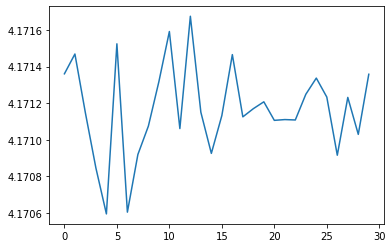

epoch : 0 iter : 0 (0m 0s) 2.3276  / check time (from watch) ✗ (throw)
epoch : 11 iter : 5 (0m 21s) 2.3198  / check time (from watch) ✗ (put on a hat/cap)
epoch : 22 iter : 10 (0m 43s) 2.3027  / check time (from watch) ✗ (put on a hat/cap)
epoch : 33 iter : 15 (1m 4s) 2.3323  / check time (from watch) ✗ (throw)
epoch : 44 iter : 20 (1m 26s) 2.3250  / check time (from watch) ✗ (drop)
epoch : 55 iter : 25 (1m 47s) 2.3330  / check time (from watch) ✗ (salute)
epoch : 66 iter : 30 (2m 9s) 2.2934  / check time (from watch) ✗ (put on a hat/cap)
epoch : 77 iter : 35 (2m 30s) 2.3065  / check time (from watch) ✗ (put on a hat/cap)
epoch : 88 iter : 40 (2m 52s) 2.3238  / check time (from watch) ✗ (salute)
epoch : 100 iter : 0 (3m 14s) 2.2980  / check time (from watch) ✗ (jump up)
epoch : 111 iter : 5 (3m 36s) 2.3312  / check time (from watch) ✗ (kicking something)
epoch : 122 iter : 10 (3m 57s) 2.3053  / check time (from watch) ✗ (throw)
epoch : 133 iter : 15 (4m 19s) 2.3340  / check time (from 

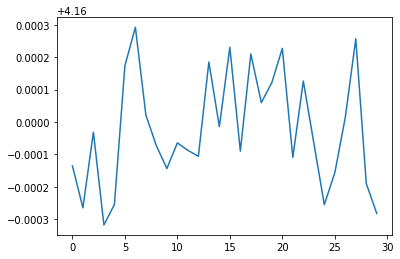

epoch : 0 iter : 0 (0m 0s) 2.2989  / throw ✗ (kicking something)
epoch : 11 iter : 5 (0m 24s) 2.3172  / throw ✗ (drop)
epoch : 22 iter : 10 (0m 48s) 2.3217  / throw ✗ (drop)
epoch : 33 iter : 15 (1m 13s) 2.3098  / throw ✗ (drop)
epoch : 44 iter : 20 (1m 37s) 2.2865  / throw ✗ (jump up)
epoch : 55 iter : 25 (2m 2s) 2.2965  / throw ✗ (check time (from watch))
epoch : 66 iter : 30 (2m 26s) 2.2996  / throw ✗ (salute)
epoch : 77 iter : 35 (2m 51s) 2.3014  / throw ✗ (drop)
epoch : 88 iter : 40 (3m 15s) 2.3068  / throw ✗ (kicking something)
epoch : 100 iter : 0 (3m 40s) 2.2952  / throw ✗ (put on a hat/cap)
epoch : 111 iter : 5 (4m 4s) 2.3072  / throw ✗ (kicking something)
epoch : 122 iter : 10 (4m 29s) 2.3040  / throw ✗ (salute)
epoch : 133 iter : 15 (4m 53s) 2.2951  / throw ✗ (punching/slapping other person)
epoch : 144 iter : 20 (5m 18s) 2.3040  / throw ✗ (drop)
epoch : 155 iter : 25 (5m 42s) 2.2792  / throw ✗ (salute)
epoch : 166 iter : 30 (6m 6s) 2.2945  / throw ✗ (punching/slapping other

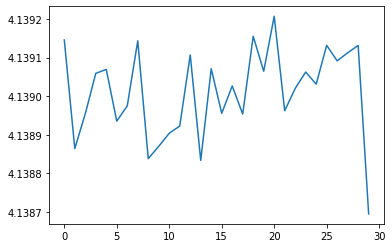

In [ ]:
for layer in [4, 8, 12]:

    n_hidden = 128
    n_joints = 25*3
    n_categories = len(LABELS)
    model = LSTM_net(n_joints, n_hidden, n_categories, layer)
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    learning_rate = 0.0007
    optimizer = optim.SGD(rnn.parameters(), lr=learning_rate, momentum=0.9)

    all_losses = []
    start = time.time()
    counter = 0
    for epoch in range(600):  
        current_loss = 0
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
        
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
    
            output = model(inputs.float())
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step() 


            current_loss += loss.item()
            category = LABELS[int(labels[0])]

            if counter % 500 == 0:
                guess, guess_i = categoryFromOutput(output)
                correct = '✓' if guess == category else '✗ (%s)' % category
                print('epoch : %d iter : %d (%s) %.4f  / %s %s' % (epoch, i, timeSince(start), loss, guess, correct))

        
            counter = counter + 1
        if counter % 100 == 0:
            all_losses.append(current_loss / 25)
            current_loss = 0

    plt.plot(list(range(0, len(all_losses))), all_losses)
    plt.show()

    result['rnn_layers'+ str(layer)] = result_model(model, test_loader)

In [ ]:
pd.DataFrame.from_dict(data=result, orient='index', columns=['accuracy'])

,accuracy
rnn_layers2,75.313808
rnn_layers4,75.313808
rnn_layers8,75.313808
rnn_layers12,75.313808


Очень странно при изменении скрытого слоя результат остался точно такой же, скорее всего тут моя ошибка. 

### Изменим количество кадров

In [ ]:
dataset25 = Skeleton_Dataset(file_path="/content/drive/MyDrive/skeleton25.csv", chonk=25, transform=None)
dataset75 = Skeleton_Dataset(file_path="/content/drive/MyDrive/skeleton75.csv", chonk=75, transform=None)

In [ ]:
train_len25 = int(0.75*len(dataset25))
test_len25 = len(dataset25) - train_len25

train_dataset25, test_dataset25 = torch.utils.data.random_split(dataset25, [train_len25, test_len25])

train_loader25 = DataLoader(train_dataset25, batch_size=16, shuffle=True)
test_loader25 = DataLoader(test_dataset25, batch_size=1, shuffle=True)

In [ ]:
n_hidden = 128
n_joints = 25*3
n_categories = len(LABELS)
n_layer = 2
rnn2 = LSTM_net(n_joints, n_hidden, n_categories, n_layer)
rnn2.to(device)

LSTM_net(
  (lstm): LSTM(75, 128, num_layers=2, batch_first=True)
  (dr): Dropout2d(p=0.1, inplace=False)
  (fc): Linear(in_features=128, out_features=10, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.0007
optimizer = optim.SGD(rnn2.parameters(), lr=learning_rate, momentum=0.9)

all_losses = []
start = time.time()
counter = 0
for epoch in range(600):  
    current_loss = 0
    running_loss = 0.0
    for i, data in enumerate(train_loader25, 0):
        
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
    
        output = rnn2(inputs.float())
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step() 


        current_loss += loss.item()
        category = LABELS[int(labels[0])]

        if counter % 500 == 0:
            guess, guess_i = categoryFromOutput(output)
            correct = '✓' if guess == category else '✗ (%s)' % category
            print('epoch : %d iter : %d (%s) %.4f  / %s %s' % (epoch, i, timeSince(start), loss, guess, correct))

        
        counter = counter + 1
    if counter % 100 == 0:
        all_losses.append(current_loss / 25)
        current_loss = 0

epoch : 0 iter : 0 (0m 0s) 2.3436  / shake fist ✗ (throw)
epoch : 8 iter : 44 (0m 9s) 2.1363  / put on a hat/cap ✗ (drop)
epoch : 17 iter : 31 (0m 19s) 2.1130  / put on a hat/cap ✗ (jump up)
epoch : 26 iter : 18 (0m 28s) 2.0879  / put on a hat/cap ✗ (check time (from watch))
epoch : 35 iter : 5 (0m 38s) 2.0708  / put on a hat/cap ✗ (throw)
epoch : 43 iter : 49 (0m 47s) 2.0030  / put on a hat/cap ✗ (jump up)
epoch : 52 iter : 36 (0m 57s) 1.9865  / kicking something ✗ (put on a hat/cap)
epoch : 61 iter : 23 (1m 6s) 1.8186  / check time (from watch) ✗ (drop)
epoch : 70 iter : 10 (1m 16s) 2.0241  / check time (from watch) ✗ (salute)
epoch : 78 iter : 54 (1m 26s) 1.3569  / check time (from watch) ✓
epoch : 87 iter : 41 (1m 35s) 1.5017  / punching/slapping other person ✓
epoch : 96 iter : 28 (1m 45s) 1.7445  / put on a hat/cap ✓
epoch : 105 iter : 15 (1m 54s) 1.2723  / check time (from watch) ✓
epoch : 114 iter : 2 (2m 4s) 1.6551  / put on a hat/cap ✓
epoch : 122 iter : 46 (2m 13s) 1.4328  /

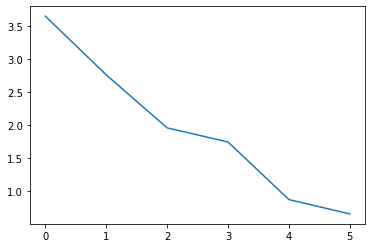

In [ ]:
plt. title('Model: ' + str(rnn2))
plt.plot(list(range(0, len(all_losses))), all_losses)
plt.show()

In [ ]:
result['rnn_layers2_25'] = result_model(rnn2, test_loader25)
pd.DataFrame.from_dict(data=result, orient='index', columns=['accuracy'])

,accuracy
rnn_layers2,75.313808
rnn_layers4,75.313808
rnn_layers8,75.313808
rnn_layers12,75.313808
rnn_layers2_25,45.065789


При измении количества кадров точность упала, не факт что при увелечении она возрастет, но это нужно проверять. Лучшую точность на мой взгляд показала первая модель. 